# Additional training pipeline features

## Bucket iterator

As we have sequences with different lengths, we have to adjust them to the same length for correct batching.

Let's look at the example:
- we have four sequences;
- batch size is 2

We have to add one padding token to the first sequence –> batch sequence length will be 5

and 3 padding tokens to the third sequence –> second batch sequence length will be 6

![default_batching](images/default_batching.png)

Overall we have added 4 padding tokens. It means that we'll have to do additional calculations for 4 more tokens.

Can we optimize the batching procedures and reduce the number of padding tokens?

Answer: Sort sequences by length

![image.png](images/optimal_batching.png)

For our example, we reduced the number of padded tokens from 4 to 2.

# Callbacks

A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

You define and use a callback when you want to automate some tasks after every training/epoch that help you have controls over the training process. This includes stopping training when you reach a certain accuracy/loss score, saving your model as a checkpoint after each successful epoch, adjusting the learning rates over time, and more. Let’s dive deep into some callback functions!


## Early Stopping
 
Overfitting is a nightmare for Machine Learning practitioners. One way to avoid overfitting is to terminate the process early. And don't waste time on useless training epochs and save only the best model weights.

![early_stopping](images/early_stopping.png)

**Patience** – number of iterations which we are ready to wait for improvements.

Moreover, we can use an additional parameter for representing a minimum improvement value. If this value is bigger than improvement over iteration, we'll not count it as an improvement.

## Tensorboard

Saving metrics is another very important callback for comparing different model architectures or specifications. 
[Here](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) you can find a detailed tutorial for different purposes. 
Pay your additional attention to a [tracking metrics section](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html#tracking-model-training-with-tensorboard).

![tensorboard](images/tensorboard.png)

## Learning Rate Schedules

**Learning rate schedules** seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. Common learning rate schedules include time-based decay, step decay and exponential decay. 

### Constant Learning Rate

Constant learning rate is the default learning rate schedule, when we use the same learning rate during the whole training process.


In [1]:
from matplotlib import pyplot as plt
from torch.nn import RNN
from torch.optim import Adam
from transformers.optimization import get_constant_schedule

In [2]:
model = RNN(100, 100)

In [3]:
optimizer = Adam(model.parameters())

In [4]:
number_of_steps = 10000

In [5]:
def get_lr_values(lr_schedule):
    lr_values = []
    for _ in range(number_of_steps):
        lr_values.append(lr_schedule.get_last_lr()[0])
        lr_schedule.step()
    return lr_values

In [6]:
def visualize_lr_schedule(lr_constant_schedule):
    lr_values = get_lr_values(lr_constant_schedule)
    
    plt.plot(lr_values);
    plt.ylabel("lr_value", fontsize=14)
    plt.xlabel("step", fontsize=14)

In [7]:
lr_constant_schedule = get_constant_schedule(optimizer)

/mnt/ssd2/home/vr/nlp-course/venv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


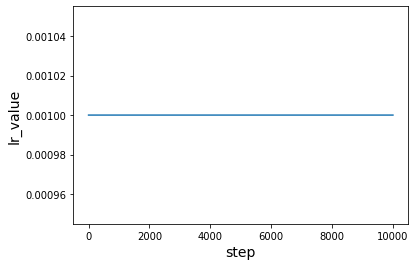

In [8]:
visualize_lr_schedule(lr_constant_schedule)

## Constant Learning Rate with WarmUp

A schedule with a constant learning rate preceded by a warmup period during which the learning rate increases linearly between 0 and the initial lr set in the optimizer.


In [9]:
warmup = 0.1

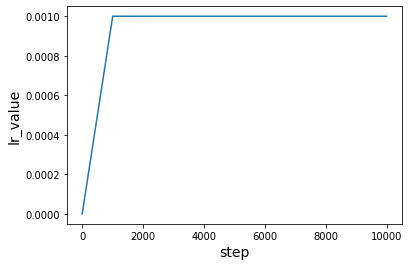

In [10]:
from transformers.optimization import get_constant_schedule_with_warmup
lr_constant_schedule_with_warmup = get_constant_schedule_with_warmup(optimizer, warmup*number_of_steps)
visualize_lr_schedule(lr_constant_schedule_with_warmup)

## Linear schedule with warmup

A schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.


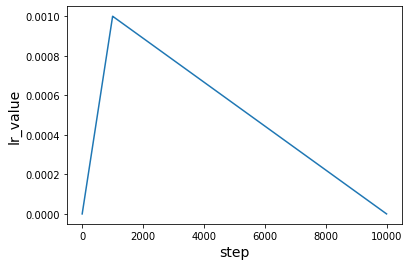

In [11]:
from transformers.optimization import get_linear_schedule_with_warmup
lr_linear_schedule_with_warmup = get_linear_schedule_with_warmup(optimizer, warmup*number_of_steps, number_of_steps)
visualize_lr_schedule(lr_linear_schedule_with_warmup)

## Cosine schedule with warmup

A schedule with a learning rate that decreases following the values of the cosine function between the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the initial lr set in the optimizer.


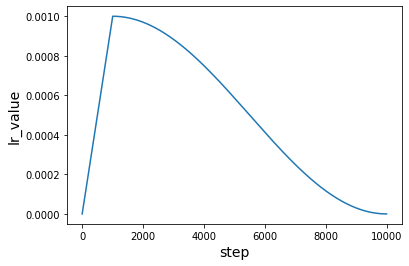

In [12]:
from transformers.optimization import get_cosine_schedule_with_warmup
lr_cosine_schedule_with_warmup = get_cosine_schedule_with_warmup(optimizer, warmup*number_of_steps, number_of_steps)
visualize_lr_schedule(lr_cosine_schedule_with_warmup)

## Cosine schedule with hard restarts and warmup

A schedule with a learning rate that decreases following the values of the cosine function between the initial lr set in the optimizer to 0, with several hard restarts, after a warmup period during which it increases linearly between 0 and the initial lr set in the optimizer.

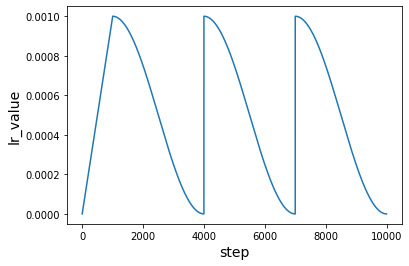

In [13]:
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup
lr_cosine_schedule_with_hard_restart_and_warmup = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, warmup*number_of_steps, number_of_steps, num_cycles=3)
visualize_lr_schedule(lr_cosine_schedule_with_hard_restart_and_warmup)

## Adam algorithm with weight decay fix

Original Adam realization has incorrect usage of weight decay. In [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) paper the problem is explained and introduced a new approach to do it correctly. 

In [14]:
from torch.optim import AdamW
from transformers.optimization import AdamW

## Gradient clipping

Gradient clipping is a technique to prevent exploding gradients in very deep networks, usually in recurrent neural networks. There are many ways to compute gradient clipping, but a common one is to rescale gradients so that their norm is at most a particular value. With gradient clipping, pre-determined gradient threshold be introduced, and  then gradients norms that exceed this threshold are scaled down to match the norm.  This prevents any gradient to have norm greater than the threshold and thus the gradients are clipped.  There is an introduced bias in the resulting values from the gradient, but gradient clipping can keep things stable. 

Training recurrent neural networks can be very difficult. Two common issues with training recurrent neural networks are vanishing gradients and exploding gradients. Exploding gradients can occur when the gradient becomes too large and error gradients accumulate, resulting in an unstable network. Vanishing gradients can happen when optimization gets stuck at a certain point because the gradient is too small to progress. Gradient clipping can prevent these issues in the gradients that mess up the parameters during training.

![clipping](images/gradient_clipping.png)

**Use after `loss.backward`**

In [15]:
from torch.nn.utils import clip_grad_norm_

So, you’ve build a nice model that might be the new SOTA on this neat task but every time you try to stack more than a few samples in a batch you get a CUDA RuntimeError: out of memory.

But you’re pretty sure that doubling the batch size will improve the results.


## Batch accumulation


Accumulating gradients just means that, before calling `optimizer.step()` to perform a step of gradient descent, we will sum the gradients of several backward operations in the `parameter.grad` tensors. This is straightforward to do in PyTorch as the gradient tensors are not reset unless we call `model.zero_grad()` or `optimizer.zero_grad()`. We’ll also need to divide by the number of accumulation steps if our loss is averaged over the training samples.



## Apex

The Apex project from NVIDIA is touted as a PyTorch extension that let developers do mixed precision and distributed training [“with 4 or fewer line changes to the existing code”](https://news.developer.nvidia.com/introducing-apex-pytorch-extension-with-tools-to-realize-the-power-of-tensor-cores/?ncid=--43654).

Install from [here]().

### Mixed Precision Training

Generally GPUs are good at doing 32-bit(single precision) math, not at 16-bit(half) nor 64-bit(double precision). Therefore traditionally deep learning model trainings are done in 32-bit.
By switching to 16-bit, we’ll be using half the memory and theoretically less computation at the expense of the available number range and precision. However, pure 16-bit training creates a lot of problems for us (imprecise weight updates, gradient underflow and overflow). Mixed precision training alleviate these problems.

![mixed_precision](images/mixed_precision.jpeg)

### Optimization Levels

The four optimization levels:
* `O0` (FP32 training): basically a no-op. Everything is FP32 just as before.
* `O1` (Conservative Mixed Precision): only some whitelist ops are done in FP16.
* `O2` (Fast Mixed Precision): this is the standard mixed precision training. It maintains FP32 master weights and optimizer.step acts directly on the FP32 master weights.
* `O3` (FP16 training): full FP16. Passing keep_batchnorm_fp32=True can speed things up as cudnn batchnorm is faster anyway.

![apex_time_comparision](images/amp_time.png)

![apex_memory_comparision](images/memory_amp.png)

## Train loop

```python
# mixed precision
if self._fp16:
    self._model, self._optimizer = amp.initialize(
        self._model, self._optimizer, opt_level=fp16_opt_level, verbosity=0
    )


batches_this_epoch = 0

for batch_group in progress_bar(
train_generator, total=num_training_batches, parent=master_bar_logger, leave=False
):
    batches_this_epoch += 1

    loss = self.batch_loss(batch_group)
    
    # gradient accumulation
    if self._accumulation_steps > 1:
        loss = loss / self._accumulation_steps

    if torch.isnan(loss):
        raise ValueError("nan loss encountered")

    # mixed precision
    if self._fp16:
        with amp.scale_loss(loss, self._optimizer) as scaled_loss:
            scaled_loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(amp.master_params(self._optimizer), self._grad_norm)  # type: ignore
    else:
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(self._model.parameters(), self._grad_norm)  # type: ignore

    train_loss += loss.item()
    # gradient accumulation
    if batches_this_epoch % self._accumulation_steps == 0:
        self._optimizer.step()
        # learning rate scheduling
        if self._lr_scheduler is not None:
            self._lr_scheduler.step()  # type: ignore
        self._model.zero_grad()
 ```